In [1]:
from utils import *
from dataset import *
from autoencoder import *
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")


In [2]:
Ashley = True
if Ashley:
    device = "cpu"

In [3]:
data = StepFunctionEventsDataset(4096,[1, 0.5, 0.25])

In [4]:
loader = DataLoader(data, batch_size=1024, shuffle=True)

In [31]:
model = Autoencoder(40, 5, 1, 1, lam = 0)
model = model.to(device)
print(device)
trainer = pl.Trainer(max_epochs=200, accelerator=device, devices=1)
history = trainer.fit(model, loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type          | Params
------------------------------------------
0 | encoder | MLP           | 2.9 K 
1 | decoder | MLP           | 513   
2 | code    | NaiveEncoding | 0     
------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)
/opt/anaconda3/envs/pvae/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/pvae/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Train

cpu
Epoch 199: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.12it/s, v_num=12]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.78it/s, v_num=12]


In [6]:
# Visualize training
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

In [32]:
# Testing data, currently just the training data
test_loader = DataLoader(data, batch_size=4096)
test_batch = next(iter(test_loader))
model.eval()
with torch.no_grad():
    model.encode(test_batch['event_list'])
    z = model.latent.cpu().numpy()


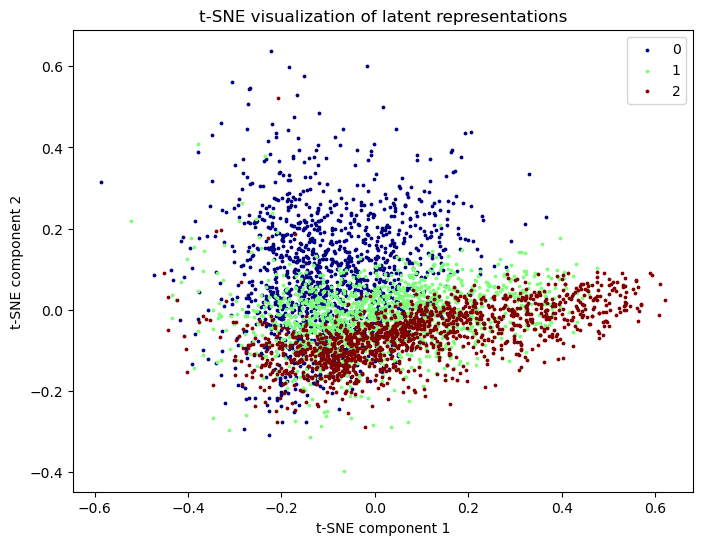

In [33]:
# from sklearn.manifold import TSNE

# # Apply t-SNE
# tsne = TSNE(n_components=2, random_state=42)
# embedding = tsne.fit_transform(z)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding = pca.fit_transform(z)

# embedding = z
labels = test_batch['type'].numpy()
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    idx = labels == label
    plt.scatter(embedding[idx, 0], embedding[idx, 1], color=colors[i], label=label, marker='o',s=3)

plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend(loc='best')
plt.title('t-SNE visualization of latent representations')
plt.show()

[[0.         0.         1.4992967  0.10595549 0.        ]
 [0.         0.         1.3034458  0.31011412 0.        ]
 [0.         0.         1.4235098  0.3403511  0.        ]
 ...
 [0.         0.         1.2466261  0.22039303 0.        ]
 [0.         0.         1.2806714  0.18093607 0.        ]
 [0.         0.         1.2721119  0.42343912 0.        ]]


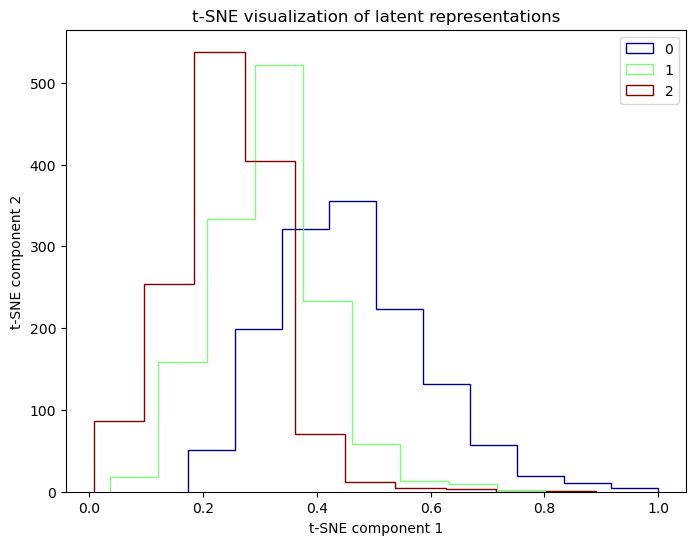

In [38]:
labels = test_batch['type'].numpy()
unique_labels = np.unique(labels)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
print(z)
plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    idx = labels == label
    plt.hist(z[idx, 3], color=colors[i], histtype='step', label=label)

plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend(loc='best')
plt.title('t-SNE visualization of latent representations')
plt.show()

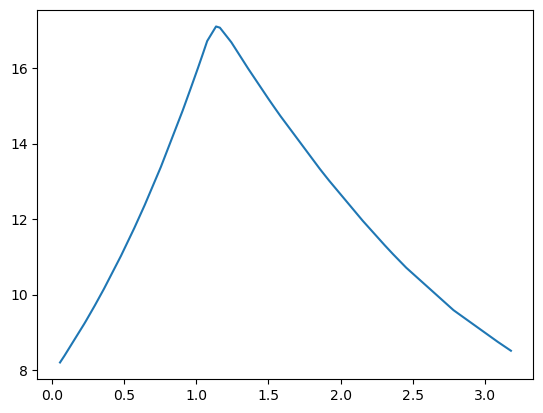

In [39]:
with torch.no_grad():
    coded = model.code(test_batch['event_list'])
    rates = model.decode(coded)
index = 12
plt.plot(coded[index,:,0], torch.exp(rates[index,:,0]))